# identify equations in Latex

https://physicsderivationgraph.blogspot.com/2020/05/characterizing-latex-content-in.html

In this notebook methods for extracting math expressions are explored:
* regex
* http://plastex.sourceforge.net/plastex/sect0025.html
* tex2py
* TexSoup

_Results_: 
* TexSoup is very slow (because it creates a complex data structure per document) and therefore isn't suitable for bulk processing. Therefore regex is preferrable
* TexSoup errors on invalid LaTeX and halts processing
* tex2py but that doesn't seem to be relevant for the tasks

### download data

data is from https://www.cs.cornell.edu/projects/kddcup/datasets.html

In [1]:
!ls -hal hep-th/2003/ | wc -l

1022


### load libraries

In [2]:
# https://github.com/alvinwan/tex2py
!pip install tex2py

In [3]:
# https://github.com/alvinwan/TexSoup
!pip install texsoup

In [4]:
!pip install plastex

In [5]:
import re
import time
import pickle # https://docs.python.org/3/library/pickle.html
import glob
import chardet
import matplotlib.pyplot as plt
import pandas

import sys
print(sys.version)

3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:39:48) 
[GCC 9.3.0]


### load data

In [6]:
list_of_files = glob.glob('hep-th/2003/*')

In [7]:
# how many files are in the corpus?

len(list_of_files)

1019

# find relevant tags for equations in latex using regex

regex likely won't work for complex latex equations. 

regex will have trouble with inline math like \\$x\\$

In [8]:
start_time=time.time()
reslts={}
number_of_eq=0
for this_file in list_of_files:
    with open(this_file,'rb') as f:
        data = f.read()
    
    resp = re.findall('\\\\begin{(?:eqnarray|equation|multiline)}.*?end{(?:eqnarray|equation|multiline)}',str(data),re.DOTALL)
#    print(this_file)
    for eq in resp:
        number_of_eq+=1
        try:
            reslts[this_file].append(eq)
        except KeyError:
            reslts[this_file]=[]
            reslts[this_file].append(eq)
#        print('  ',eq,'\n')

print(round(time.time()-start_time,2),'seconds')

8.21 seconds


How many equations were found?

In [9]:
# number of matching candidates in .tex files
number_of_eq

29481

Of the files, how many have equations present?

In [10]:
print(len(reslts.keys()),"files have equations")
print(len(list_of_files),"files")

929 files have equations
1019 files


what is an example of equations found in the first paper?

In [11]:
# first file results
reslts[list(reslts.keys())[0]]

['\\begin{equation}}\\n\\\\newcommand{\\\\eeq}{\\\\end{equation}',
 '\\begin{eqnarray}}\\n\\\\newcommand{\\\\eeqa}{\\\\end{eqnarray}']

What is the first equation in the second paper?

In [12]:
# first expression in the second file results
reslts[list(reslts.keys())[1]][0]

'\\begin{equation} \\\\eqalign{#2} \\\\label{#1} \\\\end{equation}'

## visualize results

In [13]:
number_of_eq_per_file=[]
for k,v in reslts.items():
    number_of_eq_per_file.append(len(v))

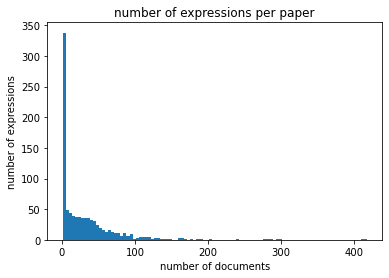

In [14]:
_=plt.hist(number_of_eq_per_file,bins=100)
_=plt.ylabel('number of expressions')
_=plt.xlabel('number of documents')
_=plt.title("number of expressions per paper")

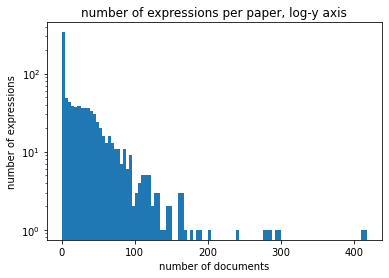

In [15]:
_=plt.hist(number_of_eq_per_file,bins=100)
_=plt.yscale('log', nonpositive='clip')
_=plt.ylabel('number of expressions')
_=plt.xlabel('number of documents')
_=plt.title("number of expressions per paper, log-y axis")

## plastex

http://plastex.sourceforge.net/plastex/sect0025.html

http://plastex.sourceforge.net/plastex/index.html

http://plastex.github.io/plastex/

In [16]:
from plasTeX.TeX import TeX
from plasTeX.Renderers.XHTML import Renderer

In [17]:
with open(list_of_files[1]) as f: data = f.read()

In [18]:
TeX(data)

## tex2py

Tex2py converts LaTeX into a Python parse tree.

https://github.com/alvinwan/tex2py - "converts LaTeX into a Python parse tree, allowing navigation using the default or a custom hierarchy"<BR>
Built on top of TexSoup

BHP: I am unable to extract math or text using this library. tex2py seems to be intended for document hierarchy

In [19]:
# https://github.com/alvinwan/tex2py
from tex2py import tex2py

In [20]:
list_of_files[2]

'hep-th/2003/0301003'

In [21]:
with open(list_of_files[1]) as f: data = f.read()

# this takes a long time because it relies on texSoup
start_time = time.time()
toc = tex2py(data)
print('elapsed =', round(time.time()-start_time,2),'seconds')

elapsed = 12.27 seconds


In [22]:
toc.branches

[Introduction,
 Thermodynamic considerations,
 Universality classes and the general problem,
 Crossing the threshold of stability: non-dilatonic\\ branes,
 Conclusions]

Not clear to me how to extract equations from the parse tree

## TexSoup

https://github.com/alvinwan/TexSoup

https://texsoup.alvinwan.com/docs/navigation.html

In [23]:
from TexSoup import TexSoup

### single file

In [24]:
file_to_open = list_of_files[3]
print(file_to_open)

hep-th/2003/0301004


https://arxiv.org/abs/hep-th/0301004

In [25]:
with open(file_to_open) as f: data = f.read()

In [26]:
start_time=time.time()
soup = TexSoup(data)
print(round(time.time()-start_time,2),'seconds')

9.24 seconds


In [27]:
list_of_math_entries = []
for entry in soup.find_all("$"):
    for this in entry.contents:
        #print(this)
        list_of_math_entries.append(this)

In [28]:
soup.equation

\begin{equation}
 \rho_N^D = \left(\prod_{i=1}^N\int d\Omega_{p_i}\right)(2\pi)^D\delta^D
 (p-\sum_{i=1}^N p_i)
\end{equation}

In [29]:
lst = list(soup.find_all('equation'))

In [30]:
len(lst) # how many equations are in the document?

22

In [31]:
lst[0] # show the first match

\begin{equation}
 \rho_N^D = \left(\prod_{i=1}^N\int d\Omega_{p_i}\right)(2\pi)^D\delta^D
 (p-\sum_{i=1}^N p_i)
\end{equation}

In [32]:
lst[0][0] # what is the string inside the "begin{equation}"?

'\n \\rho_N^D = \\left(\\prod_{i=1}^N\\int d\\Omega_{p_i}\\right)(2\\pi)^D\\delta^D\n (p-\\sum_{i=1}^N p_i)\n'

In [33]:
lst[1]

\begin{equation}
 \Phi({\bf{x}},y)=\sum_{k=-\infty}^\infty \phi_k({\bf{x}})
 \exp(iky/R)/\sqrt{2\pi R}; \quad \phi_k^*({\bf{x}}) = \phi_{-k}({\bf{x}}).
\end{equation}

In [34]:
lst[1][0]

'\n \\Phi({\\bf{x}},y)=\\sum_{k=-\\infty}^\\infty \\phi_k({\\bf{x}})\n \\exp(iky/R)/\\sqrt{2\\pi R}; \\quad \\phi_k^*({\\bf{x}}) = \\phi_{-k}({\\bf{x}}).\n'

### character encoding varies

In [35]:
with open('hep-th/2003/0302131','rb') as f:
        data = f.read()

In [36]:
chardet.detect(data)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

### loop over files

In [37]:
len(list_of_files)

1019

7531 seconds (aka 2 hours) to process 1019 latex files (from hep-th/2003)

In [38]:
start_time = time.time()

list_of_dicts = []

error_counts = {"not utf-8 decode errors": [],
                "not utf-8 and not ISO-8859-1 decode errors": [],
                "Type Error": [],
                "EOF Error": []}

for file_to_open in list_of_files:
    
    try:
        with open(file_to_open,'r', encoding='utf-8') as file_handle:
            data = file_handle.read()

        print("\nunable to decode using utf-8:", file_to_open)
        # https://stackoverflow.com/questions/19699367/for-line-in-results-in-unicodedecodeerror-utf-8-codec-cant-decode-byte
        error_counts["not utf-8 decode errors"].append(file_to_open)
            
    except UnicodeDecodeError as err:
        print(err)
        try: 
            with open(file_to_open,'r', encoding='ISO-8859-1') as file_handle:
                data = file_handle.read()
        except Exception as err:
            print(str(err)[0:300])
            error_counts["\nnot utf-8 and not ISO-8859-1 decode errors"].append(file_to_open)
            print(chardet.detect(data))
            continue
        
        
    try:
        soup = TexSoup(data)
    except TypeError as err:
        print("\nTypeError non-renderable file:",file_to_open)
        error_counts["Type Error"].append(file_to_open)
        print(str(err)[0:300]) # sometimes the error message can include the entire document, so here I limit the output to the first 200 characters
        continue # skip remaining code and go to next iteration of loop
    except EOFError as err:
        print("\nEOFError non-renderable file:",file_to_open)
        error_counts["EOF Error"].append(file_to_open)
        print(str(err)[0:300]) # sometimes the error message can include the entire document, so here I limit the output to the first 200 characters
        continue # skip remaining code and go to next iteration of loop
    
    filename = file_to_open.split("/")[-1]
    with open("soup_"+filename+".pkl","wb") as file_handle:
        pickle.dump(soup, file_handle)
    
    this_article = {"file name": file_to_open}
    
    list_of_math_entries = []
    for entry in soup.find_all("$"):
        for this in entry.contents:
            #print(this)
            list_of_math_entries.append(this)
    this_article["list of math entries"] = list_of_math_entries

    list_of_equations = []
    for entry in soup.find_all('equation'):
        for this in entry:
            list_of_equations.append(this)
            
    this_article["list of equations"] = list_of_equations
    
    list_of_dicts.append(this_article)
            
print(round(time.time()-start_time,2),'seconds')


unable to decode using utf-8: hep-th/2003/0301001

TypeError non-renderable file: hep-th/2003/0301001
Malformed argument. First and last elements must match a valid argument format. In this case, TexSoup could not find matching punctuation for: ['[', '\\mu', '}'].
Common issues include: Unescaped special characters, mistyped closing punctuation, misalignment.

unable to decode using utf-8: hep-th/2003/0301002

unable to decode using utf-8: hep-th/2003/0301003

TypeError non-renderable file: hep-th/2003/0301003
Malformed argument. First and last elements must match a valid argument format. In this case, TexSoup could not find matching punctuation for: ['[', '}'].
Common issues include: Unescaped special characters, mistyped closing punctuation, misalignment.

unable to decode using utf-8: hep-th/2003/0301004

unable to decode using utf-8: hep-th/2003/0301005

unable to decode using utf-8: hep-th/2003/0301006

TypeError non-renderable file: hep-th/2003/0301006
Malformed argument. First 

how many files were successfully souped?

In [39]:
len(list_of_dicts)

790

contents of the first file

In [ ]:
list_of_dicts[0]

what percentage of the original .tex files were souped?

In [41]:
len(list_of_dicts)/len(list_of_files)

0.7752698724239451

Not clear why I can't pickle a list of dicts

In [42]:
# https://wiki.python.org/moin/UsingPickle

with open( "all_math_and_equations.pkl", "wb" ) as file_handle:
    pickle.dump(list_of_dicts, file_handle)
    #pickle.dump([{"a":2}, {"b":3}], file_handle)

TypeError: 'NoneType' object is not callable

In [44]:
equation_and_math_counts = []
for this_dict in list_of_dicts:
    #print(this_dict["file name"],len(this_dict["list of equations"]),len(this_dict["list of math entries"]))
    equation_and_math_counts.append({"file name": this_dict["file name"],
                                     "equation count": len(this_dict["list of equations"]),
                                     "math count": len(this_dict["list of math entries"])})

how many papers have no "equation" fields?

In [48]:
sum([d['equation count']==0 for d in equation_and_math_counts])

357

how many papers have no \\$x\\$ ?

In [49]:
sum([d['math count']==0 for d in equation_and_math_counts])

58

total number of equations identified

In [50]:
sum([d['equation count'] for d in equation_and_math_counts])

18955